In [20]:
import requests
import json
import pandas as pd
from pathlib import Path

# API endpoint and query filtering drugs with names ending in "-mab" (common antibody suffix)
url = "https://api.fda.gov/drug/event.json"
params = {
    'search': 'patient.drug.medicinalproduct:"mab"',
    'limit': 10
}

response = requests.get(url, params=params)
response.raise_for_status()
data = response.json()

# Directories for bronze and silver layers
base_dir = Path("/Users/cmontefusco/PharmaRWE-Azure/data")
bronze_dir = base_dir / "bronze"
silver_dir = base_dir / "silver"

bronze_dir.mkdir(parents=True, exist_ok=True)
silver_dir.mkdir(parents=True, exist_ok=True)

# Save raw JSON to bronze
raw_path = bronze_dir / "openfda_antibody_raw.json"
with open(raw_path, 'w') as f:
    json.dump(data, f, indent=2)

print(f"Raw data saved to {raw_path}")

# Parse and flatten relevant info
results = data.get('results', [])
processed_rows = []

for event in results:
    case_id = event.get('safetyreportid')
    patient = event.get('patient', {})
    drugs = patient.get('drug', [])
    medicinal_products = [d.get('medicinalproduct') for d in drugs]
    reactions = patient.get('reaction', [])
    reaction_terms = [r.get('reactionmeddrapt') for r in reactions]

    processed_rows.append({
        'case_id': case_id,
        'medicinal_products': medicinal_products,
        'reaction_terms': reaction_terms
    })

df = pd.DataFrame(processed_rows)

# Save processed CSV to silver layer
silver_path = silver_dir / "openfda_antibody_processed.csv"
df.to_csv(silver_path, index=False)

print(f"Processed data saved to {silver_path}")

df.head()


Raw data saved to /Users/cmontefusco/PharmaRWE-Azure/data/bronze/openfda_antibody_raw.json


NameError: name 'openfda_antibody_raw' is not defined

In [18]:
df.head()

,case_id,medicinal_products,reaction_terms
0,10408858,"[PACLITAXEL., DIFFU K, RO 5479599 (ANTI-HER3 M...",[Hypokalaemia]
1,10501893,"[CETUXIMAB, ERLOTINIB, RO 5479599 (ANTI-HER 3 ...",[Hypokalaemia]
2,10578403,"[BEVACIZUMAB, BEVACIZUMAB, TRC105 (ANTI-ENDOGL...","[Hypertension, Angiopathy]"
3,10780567,"[RO 5479599 (ANTI-HER3 MAB), PACLITAXEL., CENT...",[Malaise]
4,10907473,"[FLUDARABINE, OKT3, ETOPOSIDE., ATG-FRESENIUS,...","[Thrombocytopenia, Cytomegalovirus viraemia, T..."
5,10944248,"[IVIG, INFLIXI-MAB, METHYLPREDNISOLONE., MONOC...","[Drug ineffective for unapproved indication, N..."
6,10944459,"[INFLIXI-MAB, IVIG, METHYLPREDNISOLONE., MONOC...","[No therapeutic response, Neuropathy periphera..."
7,11558508,"[RO 5479599 (ANTI-HER3 MAB), DENOSUMAB, LOPERA...",[Herpes zoster]
8,11736137,"[DOXORUBICIN HYDROCHLORIDE., IMC-3G3 (RH ANTI-...","[Infection, Thrombocytopenia, Neutropenia, Off..."
9,11767393,"[LOPERAMID, METOHEXAL, ASPIRIN., PACLITAXEL., ...","[General physical health deterioration, Urinar..."


In [22]:
import json
import pandas as pd
from pathlib import Path

# Path to your saved raw JSON in Bronze layer
raw_path = Path("/Users/cmontefusco/PharmaRWE-Azure/data/bronze/openfda_antibody_raw.json")

# Load JSON
with open(raw_path, 'r') as f:
    raw_data = json.load(f)

# Convert nested JSON to a flat table
raw_antibody_df = pd.json_normalize(raw_data['results'])

# Display first few columns
print(raw_antibody_df.shape)
raw_antibody_df.head()


(10, 34)


,safetyreportversion,safetyreportid,primarysourcecountry,occurcountry,transmissiondateformat,transmissiondate,reporttype,serious,seriousnesshospitalization,receivedateformat,...,patient.patientonsetage,patient.patientonsetageunit,patient.patientweight,patient.patientsex,patient.reaction,patient.drug,patient.summary.narrativeincludeclinical,seriousnessother,primarysource.literaturereference,seriousnessdeath
0,2,10408858,FR,FR,102,20150326,2,1,1,102,...,47,801,48,2,"[{'reactionmeddraversionpt': '17.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20140819,NaN,NaN,NaN
1,2,10501893,DK,DK,102,20160304,2,1,NaN,102,...,NaN,NaN,NaN,NaN,"[{'reactionmeddraversionpt': '18.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,1,"LASSEN U, RUIPEREZ A, FLEITAS T, MEULENDIJKS D...",NaN
2,1,10578403,US,US,102,20150529,2,1,NaN,102,...,28,801,NaN,NaN,"[{'reactionmeddraversionpt': '18.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20140519,1,NaN,NaN
3,1,10780567,DK,DK,102,20150721,2,1,1,102,...,74,801,69.2,2,"[{'reactionmeddraversionpt': '18.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 201502,NaN,NaN,NaN
4,1,10907473,DE,DE,102,20150721,1,1,NaN,102,...,6,801,NaN,2,"[{'reactionmeddraversionpt': '18.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,1,KLEIST C. GENERATION OF SUPPRESSIVE BLOOD CELL...,1


In [24]:
raw_antibody_df.describe()


,safetyreportversion,safetyreportid,primarysourcecountry,occurcountry,transmissiondateformat,transmissiondate,reporttype,serious,seriousnesshospitalization,receivedateformat,...,patient.patientonsetage,patient.patientonsetageunit,patient.patientweight,patient.patientsex,patient.reaction,patient.drug,patient.summary.narrativeincludeclinical,seriousnessother,primarysource.literaturereference,seriousnessdeath
count,10,10,10,10,10,10,10,10,4,10,...,8,8,4,7,10,10,5,6,3,1
unique,2,10,4,4,1,5,2,1,1,1,...,7,1,4,2,10,10,5,1,3,1
top,2,10408858,US,US,102,20160304,2,1,1,102,...,57,801,48,2,"[{'reactionmeddraversionpt': '17.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",CASE EVENT DATE: 20140819,1,"LASSEN U, RUIPEREZ A, FLEITAS T, MEULENDIJKS D...",1
freq,5,1,4,4,10,4,6,10,4,10,...,2,8,1,5,1,1,1,6,1,1


In [30]:
import json
import pandas as pd
from pathlib import Path

# Path to raw JSON in Bronze
raw_path = Path("/Users/cmontefusco/PharmaRWE-Azure/data/bronze/openfda_antibody_raw.json")

# Load raw JSON
with open(raw_path, 'r') as f:
    raw_data = json.load(f)

# Flatten the JSON
df_raw = pd.json_normalize(raw_data['results'])

# Extract only the columns we need for now
# These columns contain lists
df_exploded = df_raw[['safetyreportid', 'patient.drug', 'patient.reaction']].copy()

# Step 1: Explode the drugs list
df_exploded = df_exploded.explode('patient.drug').reset_index(drop=True)

# Step 2: From each drug dict, extract medicinal product name
df_exploded['medicinal_product'] = df_exploded['patient.drug'].apply(
    lambda d: d.get('medicinalproduct') if isinstance(d, dict) else None
)

# Step 3: Explode the reactions list
df_exploded = df_exploded.explode('patient.reaction').reset_index(drop=True)

# Step 4: From each reaction dict, extract the MedDRA term
df_exploded['reaction_term'] = df_exploded['patient.reaction'].apply(
    lambda r: r.get('reactionmeddrapt') if isinstance(r, dict) else None
)

# Step 5: Keep only relevant columns
silver_antibody_df = df_exploded[['safetyreportid', 'medicinal_product', 'reaction_term']]

# Optional: drop rows with missing values
silver_antibody_df = silver_antibody_df.dropna(subset=['medicinal_product', 'reaction_term'])

# Save to Silver layer
silver_path = Path("/Users/cmontefusco/PharmaRWE-Azure/data/silver/openfda_antibody_exploded.csv")
silver_antibody_df.to_csv(silver_path, index=False)

print(f"Exploded DataFrame saved to {silver_path}")
silver_antibody_df.head(20)


Exploded DataFrame saved to /Users/cmontefusco/PharmaRWE-Azure/data/silver/openfda_antibody_exploded.csv


,safetyreportid,medicinal_product,reaction_term
0,10408858,PACLITAXEL.,Hypokalaemia
1,10408858,DIFFU K,Hypokalaemia
2,10408858,RO 5479599 (ANTI-HER3 MAB),Hypokalaemia
3,10408858,PERTUZUMAB,Hypokalaemia
4,10408858,PERTUZUMAB,Hypokalaemia
5,10501893,CETUXIMAB,Hypokalaemia
6,10501893,ERLOTINIB,Hypokalaemia
7,10501893,RO 5479599 (ANTI-HER 3 MAB),Hypokalaemia
8,10501893,RO 5479599 (ANTI-HER 3 MAB),Hypokalaemia
9,10501893,RO 5479599 (ANTI-HER 3 MAB),Hypokalaemia


In [32]:
import json
import pandas as pd
from pathlib import Path

# === Paths ===
base_dir = Path("/Users/cmontefusco/PharmaRWE-Azure/data")
bronze_path = base_dir / "bronze/openfda_antibody_raw.json"
silver_path = base_dir / "silver/openfda_antibody_exploded.csv"
gold_path = base_dir / "gold/openfda_antibody_counts.csv"

# === Load raw JSON from Bronze layer ===
with open(bronze_path, 'r') as f:
    raw_data = json.load(f)

# === Flatten JSON ===
df_raw = pd.json_normalize(raw_data['results'])

# === Keep only drug and reaction columns ===
df_exploded = df_raw[['safetyreportid', 'patient.drug', 'patient.reaction']].copy()

# === Explode drugs ===
df_exploded = df_exploded.explode('patient.drug').reset_index(drop=True)
df_exploded['medicinal_product'] = df_exploded['patient.drug'].apply(
    lambda d: d.get('medicinalproduct') if isinstance(d, dict) else None
)

# === Explode reactions ===
df_exploded = df_exploded.explode('patient.reaction').reset_index(drop=True)
df_exploded['reaction_term'] = df_exploded['patient.reaction'].apply(
    lambda r: r.get('reactionmeddrapt') if isinstance(r, dict) else None
)

# === Silver layer DataFrame ===
antibody_df = df_exploded[['safetyreportid', 'medicinal_product', 'reaction_term']].dropna()

# Save Silver layer
antibody_df.to_csv(silver_path, index=False)
print(f"Silver layer saved to {silver_path}")

# === Gold layer: aggregate counts ===
gold_df = (
    antibody_df
    .groupby(['medicinal_product', 'reaction_term'])
    .size()
    .reset_index(name='count')
    .sort_values(['count'], ascending=False)
)

# Save Gold layer
gold_df.to_csv(gold_path, index=False)
print(f"Gold layer saved to {gold_path}")

# Preview
print("\nTop drug–reaction pairs:")
gold_df.head(10)


Silver layer saved to /Users/cmontefusco/PharmaRWE-Azure/data/silver/openfda_antibody_exploded.csv
Gold layer saved to /Users/cmontefusco/PharmaRWE-Azure/data/gold/openfda_antibody_counts.csv

Top drug–reaction pairs:


,medicinal_product,reaction_term,count
184,TRC105 (ANTI-ENDOGLIN MAB),Hypertension,4
183,TRC105 (ANTI-ENDOGLIN MAB),Angiopathy,4
155,RO 5479599 (ANTI-HER 3 MAB),Hypokalaemia,4
69,LOPERAMID,Gastric ulcer,3
74,LOPERAMID,Urinary tract infection,3
73,LOPERAMID,Ileus paralytic,3
72,LOPERAMID,Helicobacter test positive,3
71,LOPERAMID,General physical health deterioration,3
70,LOPERAMID,Gastritis,3
137,PERTUZUMAB,Herpes zoster,3


In [34]:
import json
import pandas as pd
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# === Paths ===
base_dir = Path("/Users/cmontefusco/PharmaRWE-Azure/data")
bronze_path = base_dir / "bronze/openfda_antibody_raw.json"
silver_path = base_dir / "silver/openfda_antibody_exploded.csv"
gold_path = base_dir / "gold/openfda_antibody_counts.csv"

# === Load raw JSON (Bronze) ===
with open(bronze_path, 'r') as f:
    raw_data = json.load(f)

# === Flatten JSON ===
df_raw = pd.json_normalize(raw_data['results'])

# === Silver layer: flatten & explode ===
df_exploded = df_raw[['safetyreportid', 'patient.drug', 'patient.reaction']].copy()

df_exploded = df_exploded.explode('patient.drug').reset_index(drop=True)
df_exploded['medicinal_product'] = df_exploded['patient.drug'].apply(
    lambda d: d.get('medicinalproduct') if isinstance(d, dict) else None
)

df_exploded = df_exploded.explode('patient.reaction').reset_index(drop=True)
df_exploded['reaction_term'] = df_exploded['patient.reaction'].apply(
    lambda r: r.get('reactionmeddrapt') if isinstance(r, dict) else None
)

antibody_df = df_exploded[['safetyreportid', 'medicinal_product', 'reaction_term']].dropna()

silver_path.parent.mkdir(parents=True, exist_ok=True)
antibody_df.to_csv(silver_path, index=False)
print(f"Silver layer saved to {silver_path}")

# === Gold layer: aggregate counts ===
gold_df = (
    antibody_df
    .groupby(['medicinal_product', 'reaction_term'])
    .size()
    .reset_index(name='count')
    .sort_values(['count'], ascending=False)
)

gold_path.parent.mkdir(parents=True, exist_ok=True)
gold_df.to_csv(gold_path, index=False)
print(f"Gold layer saved to {gold_path}")

# === ML Step: Drug clustering based on reaction profiles ===

# Pivot Gold layer into drug x reaction matrix
pivot_df = gold_df.pivot_table(index='medicinal_product',
                               columns='reaction_term',
                               values='count',
                               fill_value=0)

# Run KMeans clustering (3 clusters for demo purposes)
kmeans = KMeans(n_clusters=3, random_state=42)
pivot_df['cluster'] = kmeans.fit_predict(pivot_df)

# Preview clusters
print("\nDrug clusters:")
print(pivot_df[['cluster']].sort_values(by='cluster').head(10))


Silver layer saved to /Users/cmontefusco/PharmaRWE-Azure/data/silver/openfda_antibody_exploded.csv
Gold layer saved to /Users/cmontefusco/PharmaRWE-Azure/data/gold/openfda_antibody_counts.csv

Drug clusters:
reaction_term          cluster
medicinal_product             
IVIG                         0
MONOCLONAL ANTIBODIES        0
METHYLPREDNISOLONE.          0
INFLIXI-MAB                  0
NOVALGIN                     1
JODID                        1
PACLITAXEL.                  1
PANTOPRAZOL                  1
PERENTEROL                   1
PERTUZUMAB                   1


Silver layer saved to /Users/cmontefusco/PharmaRWE-Azure/data/silver/openfda_antibody_exploded.csv
Gold layer saved to /Users/cmontefusco/PharmaRWE-Azure/data/gold/openfda_antibody_counts.csv


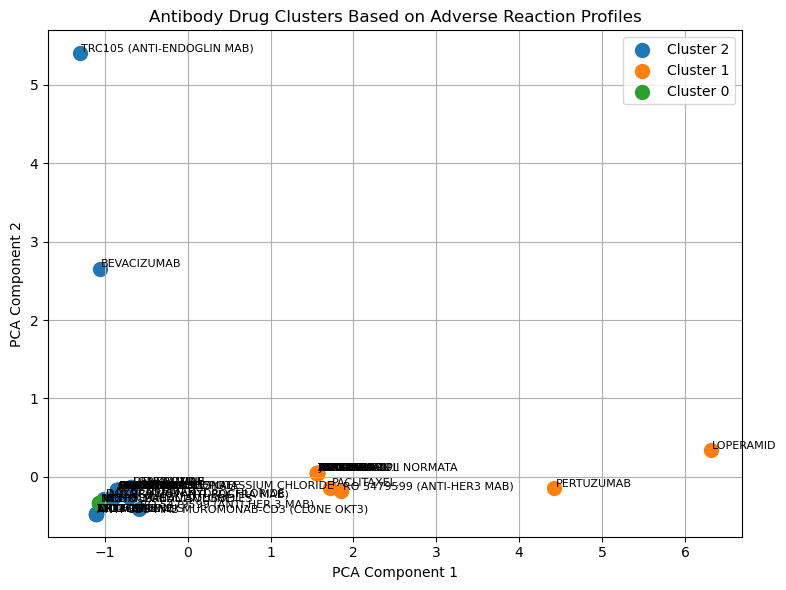

Cluster plot saved to /Users/cmontefusco/PharmaRWE-Azure/data/gold/antibody_clusters.png


In [36]:
import json
import pandas as pd
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# === Paths ===
base_dir = Path("/Users/cmontefusco/PharmaRWE-Azure/data")
bronze_path = base_dir / "bronze/openfda_antibody_raw.json"
silver_path = base_dir / "silver/openfda_antibody_exploded.csv"
gold_path = base_dir / "gold/openfda_antibody_counts.csv"

# === Load raw JSON (Bronze) ===
with open(bronze_path, 'r') as f:
    raw_data = json.load(f)

# === Flatten JSON (Silver) ===
df_raw = pd.json_normalize(raw_data['results'])
df_exploded = df_raw[['safetyreportid', 'patient.drug', 'patient.reaction']].copy()

df_exploded = df_exploded.explode('patient.drug').reset_index(drop=True)
df_exploded['medicinal_product'] = df_exploded['patient.drug'].apply(
    lambda d: d.get('medicinalproduct') if isinstance(d, dict) else None
)

df_exploded = df_exploded.explode('patient.reaction').reset_index(drop=True)
df_exploded['reaction_term'] = df_exploded['patient.reaction'].apply(
    lambda r: r.get('reactionmeddrapt') if isinstance(r, dict) else None
)

antibody_df = df_exploded[['safetyreportid', 'medicinal_product', 'reaction_term']].dropna()

silver_path.parent.mkdir(parents=True, exist_ok=True)
antibody_df.to_csv(silver_path, index=False)
print(f"Silver layer saved to {silver_path}")

# === Gold layer ===
gold_df = (
    antibody_df
    .groupby(['medicinal_product', 'reaction_term'])
    .size()
    .reset_index(name='count')
    .sort_values(['count'], ascending=False)
)

gold_path.parent.mkdir(parents=True, exist_ok=True)
gold_df.to_csv(gold_path, index=False)
print(f"Gold layer saved to {gold_path}")

# === ML Step: Pivot & Cluster ===
pivot_df = gold_df.pivot_table(index='medicinal_product',
                               columns='reaction_term',
                               values='count',
                               fill_value=0)

kmeans = KMeans(n_clusters=3, random_state=42)
pivot_df['cluster'] = kmeans.fit_predict(pivot_df)

# === PCA for 2D visualization ===
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(pivot_df.drop(columns='cluster'))

pivot_df['pca_x'] = coords[:, 0]
pivot_df['pca_y'] = coords[:, 1]

# === Plot ===
plt.figure(figsize=(8, 6))
for cluster_id in pivot_df['cluster'].unique():
    cluster_points = pivot_df[pivot_df['cluster'] == cluster_id]
    plt.scatter(cluster_points['pca_x'], cluster_points['pca_y'], label=f"Cluster {cluster_id}", s=100)

# Annotate drug names
for drug, row in pivot_df.iterrows():
    plt.text(row['pca_x'] + 0.02, row['pca_y'] + 0.02, drug, fontsize=8)

plt.title("Antibody Drug Clusters Based on Adverse Reaction Profiles")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save plot to gold layer
plot_path = base_dir / "gold/antibody_clusters.png"
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"Cluster plot saved to {plot_path}")


Note: you may need to restart the kernel to use updated packages.


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


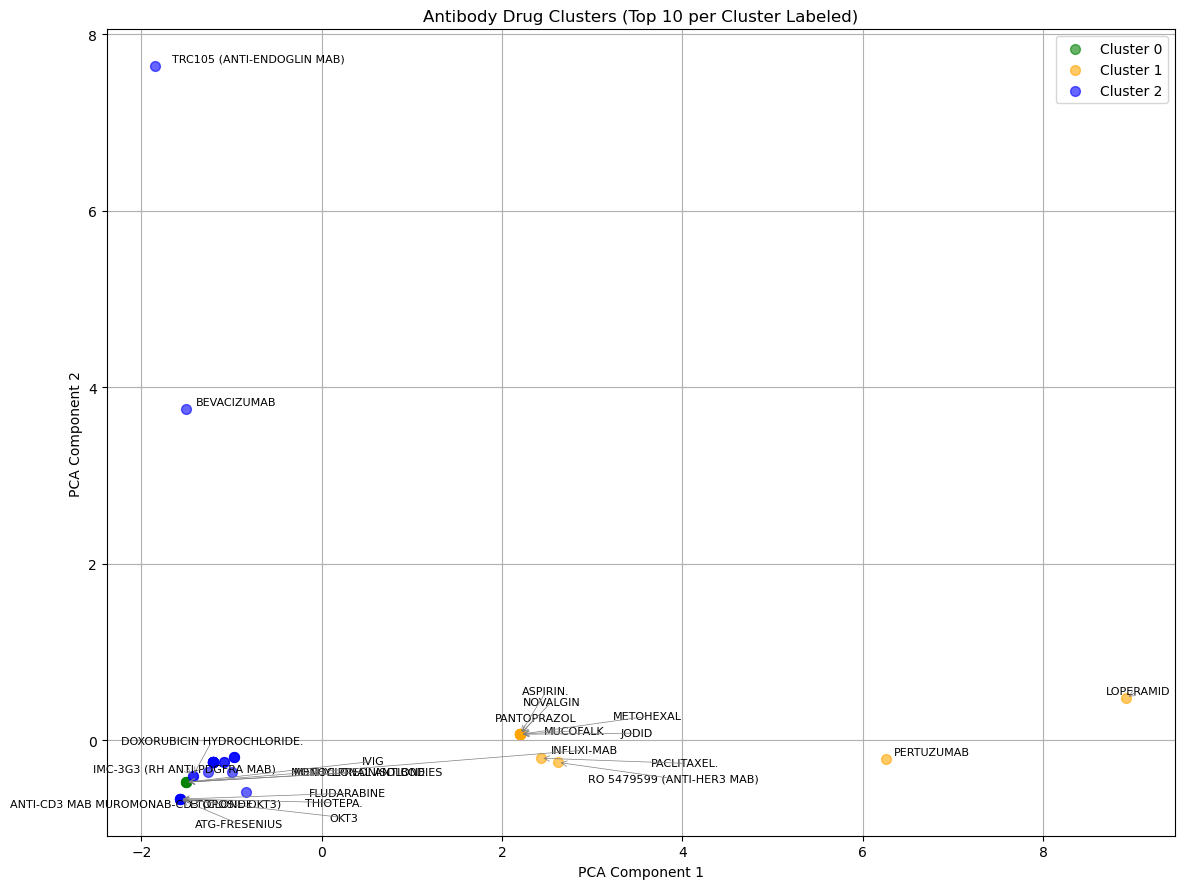

In [42]:
%pip install adjustText

import matplotlib.pyplot as plt
from adjustText import adjust_text
import pandas as pd
from sklearn.decomposition import PCA

# --- PCA for plotting ---
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(pivot_df.drop(columns='cluster'))

plot_df = pivot_df.copy()
plot_df['pca_x'] = pca_coords[:, 0]
plot_df['pca_y'] = pca_coords[:, 1]

# Merge reaction counts to get top drugs
top_counts = (
    gold_df.groupby('medicinal_product')['count']
    .sum()
    .reset_index()
    .rename(columns={'count': 'total_count'})
)
plot_df = plot_df.merge(top_counts, left_index=True, right_on='medicinal_product')

# --- Plot ---
plt.figure(figsize=(12, 9))
colors = {0: 'green', 1: 'orange', 2: 'blue'}

for cluster_id, cluster_points in plot_df.groupby('cluster'):
    plt.scatter(
        cluster_points['pca_x'], cluster_points['pca_y'],
        label=f"Cluster {cluster_id}", 
        color=colors[cluster_id], alpha=0.6, s=50
    )

# Select top 10 drugs per cluster for labeling
texts = []
for cluster_id, cluster_points in plot_df.groupby('cluster'):
    top_drugs = cluster_points.nlargest(10, 'total_count')
    for _, row in top_drugs.iterrows():
        texts.append(
            plt.text(row['pca_x'], row['pca_y'], row['medicinal_product'], fontsize=8)
        )

# Adjust labels to avoid overlap
adjust_text(
    texts, 
    arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
    expand_points=(1.2, 1.4)
)

plt.title("Antibody Drug Clusters (Top 10 per Cluster Labeled)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(base_dir / "gold/antibody_clusters_clean.png", dpi=300)
plt.show()
